In [112]:
import numpy as np
import gbm
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
from astropy.io import fits
from functions import find_files, plot_MVT_,plot_Amati_rel


In [42]:
# to do: implement the real function that compute MVT
# to do: implement log_likelihood in the case no redshift
# to do: implement a spectral fit to get Ep and fluence

**1. Load data from Fermi/GBM**

In [113]:
# reduce gbm data
# select the fermi id of the burst
fermi_id = "bn260111690"
energy_range = (8, 1000)  # in keV
bin_time = 0.064  # in seconds
bin_time_str = str(int(bin_time*1000))

bin_time_rb = 1.024  # in seconds for the background
rebf = int(bin_time_rb / bin_time)

# test if the data is already downloaded by checking if the folder exists
data_folder = f"./{fermi_id}"
if not os.path.exists(data_folder):
    # write a line of code from the terminal to download the data
    os.system(f"../take_GBM_burst_data.sh {fermi_id}")
if not os.path.exists(f"{fermi_id}/LC"):
    os.makedirs(f"{fermi_id}/LC")

In [114]:

file_path_bcat = find_files(f'{fermi_id}/glg_bcat_all_{fermi_id}_v*.fit')

filename = file_path_bcat
with fits.open(filename) as hdul:
    # Access the Primary Header (Metadata)
    header = hdul[0].header
    t90 = hdul[0].header['T90']
    t90_start = hdul[0].header['T90START']
    fluence = hdul[0].header['FLU']
    fluence_err = hdul[0].header['FLU_ERR']
    # Print every line ("Card") nicely
    print(f"{'KEYWORD':<10} = {'VALUE':<20} / {'COMMENT'}")
    print("-" * 60)
    
    for card in header.cards:
        print(card)

OSError: File-like object does not have a 'write' method, required for mode 'ostream'.

In [115]:
file_path_tcat = find_files(f'{fermi_id}/glg_tcat_all_{fermi_id}_v*.fit')

with fits.open(file_path_tcat) as hdul:
    # The mask is usually in the Primary header (index 0)
    det_mask = hdul[0].header['DET_MASK']
    detectors = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1']
    used_detectors = [det for i, det in enumerate(detectors) if det_mask[i] == '1']
    print(f"Used Detectors: {used_detectors}")
    # convert used_detectors to a str separated by _
    used_detectors_str = '_'.join(used_detectors)

Using the latest version: bn260111690/glg_tcat_all_bn260111690_v00.fit
Used Detectors: ['n0', 'n6', 'n9']


In [116]:
tte_files=[]
ttes=[]
for det in used_detectors:
    tte_files.append(find_files(f'{fermi_id}/glg_tte_{det}_{fermi_id}_v*.fit'))
    ttes.append(TTE.open(tte_files[-1]))
tte_files


det_time, det_counts, det_err_counts = [], [], []
for det in ttes:
    phaii = det.to_phaii(bin_by_time, bin_time, time_ref = 0.0)
    lc = phaii.to_lightcurve(energy_range = energy_range)
    counts = lc.counts 
    err_counts = np.sqrt(lc.counts+3/4)+1
    time = lc.centroids
    det_time.append(time)
    det_counts.append(counts)
    det_err_counts.append(err_counts)

Using the latest version: bn260111690/glg_tte_n0_bn260111690_v00.fit
Using the latest version: bn260111690/glg_tte_n6_bn260111690_v00.fit
Using the latest version: bn260111690/glg_tte_n9_bn260111690_v00.fit


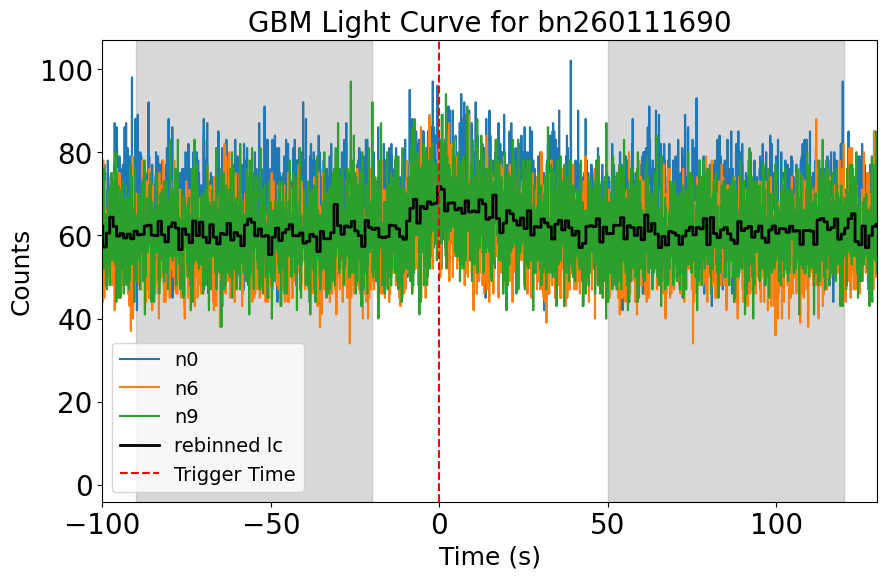

In [118]:
# choose the bkgd intervals
bkgd_intervals = [(-90, -20), (50, 120)]
t1, t2, t3, t4 = bkgd_intervals[0][0], bkgd_intervals[0][1], bkgd_intervals[1][0], bkgd_intervals[1][1]
plt.figure(figsize=(10,6))
# plot the light curve for all used detectors
for i, det in enumerate(used_detectors):
    plt.step(det_time[i], det_counts[i], where='mid', label=det)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# rebin the light curve to 1s
import sys
from turtle import bk

from numpy import average 
sys.path.append('/astrodata/romain/')
from sax_utils import rebin_lc_genau


x_reb,y_reb,z_reb = rebin_lc_genau(det_time[-1], det_counts[-1], det_err_counts[-1],rebf,ren=True)

plt.step(x_reb, y_reb, where='mid', label='rebinned lc', color='k', linewidth=2)
plt.axvspan(bkgd_intervals[0][0],bkgd_intervals[0][1], color='gray', alpha=0.3)
plt.axvspan(bkgd_intervals[1][0],bkgd_intervals[1][1], color='gray', alpha=0.3)
#plt.axvspan(t90_start, t90_start+t90, color='red', alpha=0.3)
#plt.xlim(t90_start-0.5*t90, t90_start+3*t90)
plt.xlim(bkgd_intervals[0][0]-10, bkgd_intervals[1][1]+10)
plt.axvline(x=0, color='r', linestyle='--', label='Trigger Time')
plt.title(f'GBM Light Curve for {fermi_id}', fontsize=20)
plt.legend(fontsize=14)



In [59]:
################################################################
# Find the intersection of all detectors' time
###############################################################
t11 = np.max([det_time[kk][0] for kk in range(len(det_time))])
t22 = np.min([det_time[kk][-1] for kk in range(len(det_time))])

for jj in range(len(det_time)):
    ind = np.where(  (det_time[jj]>t11) & (det_time[jj]<t22) )[0]
    det_time[jj] = det_time[jj][ind]
    det_counts[jj] = det_counts[jj][ind]
    det_err_counts[jj] = det_err_counts[jj][ind]

# do the same for the rebinned lc
ind = np.where(  (x_reb>t11) & (x_reb<t22) )[0]


print(len(det_time[0]),len(det_time[1]),len(det_time[2]))
print(len(det_counts[0]),len(det_counts[1]),len(det_counts[2]))
print(len(det_err_counts[0]),len(det_err_counts[1]),len(det_err_counts[2]))

598023 598023 598023
598023 598023 598023
598023 598023 598023


-->  Deg 3 polynomial parameters: [-1.12742274e-08  1.97528489e-06  1.85845014e-04  2.87678484e+00]
Residuals Mean: 9.13606431275563e-05, Std: 0.7860834008298585


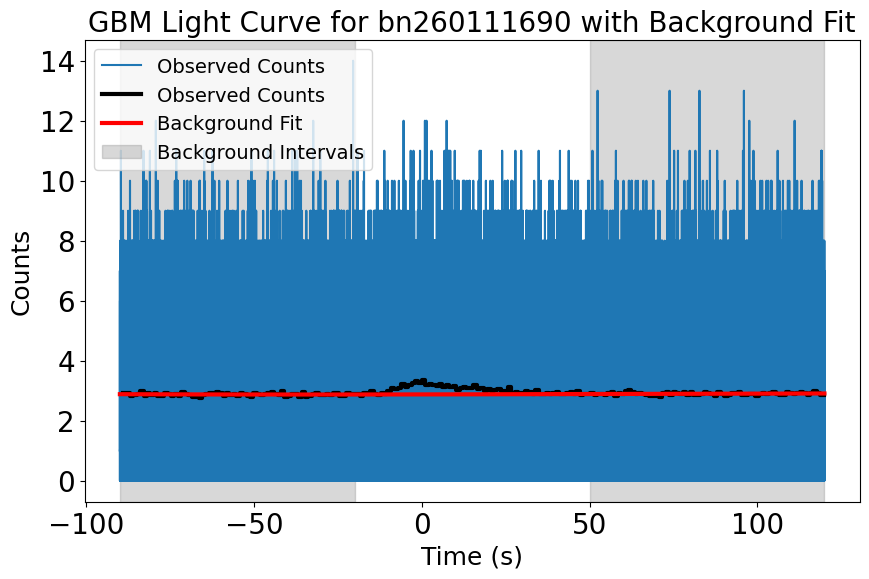

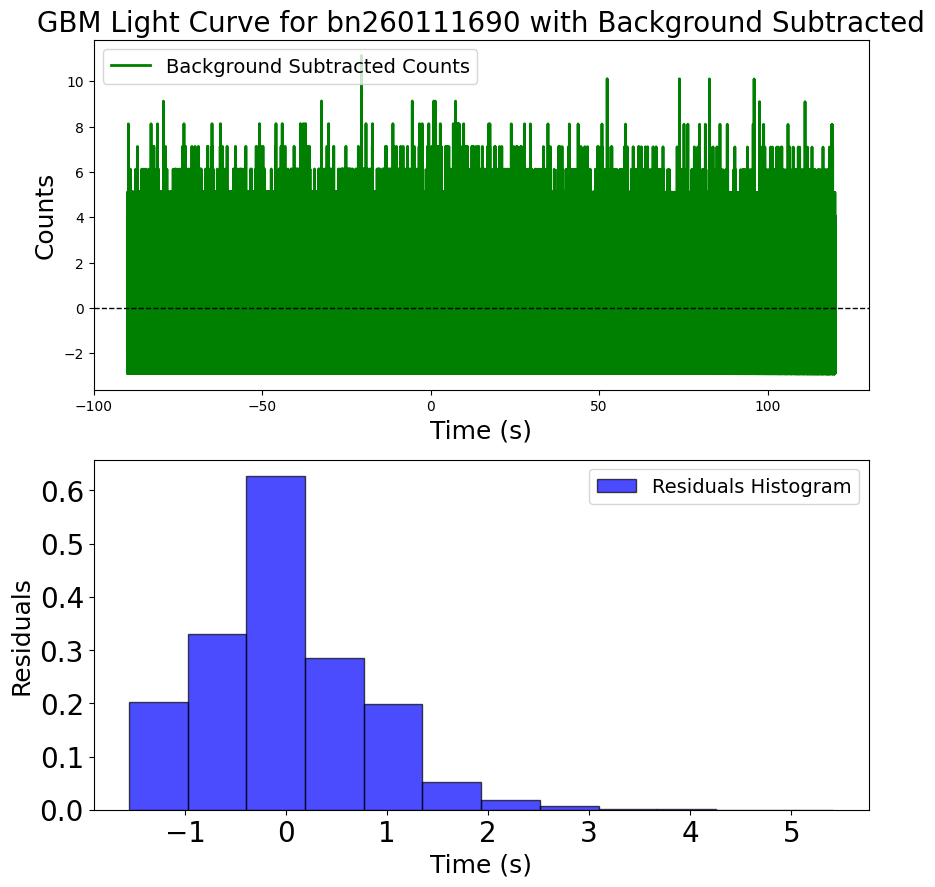

In [60]:
# sum the counts of all used detectors
time = det_time[0]

counts_tot = np.zeros(len(det_counts[0]))
counts_tot_reb = np.zeros(len(x_reb))
for k in range(len(det_counts)):
    counts_tot+= det_counts[k]
    x_reb_det,y_reb_det,z_reb_det = rebin_lc_genau(det_time[k], det_counts[k], det_err_counts[k],rebf,ren=True)
    counts_tot_reb += y_reb_det

det_err_counts_tot_squared= np.zeros(len(det_counts[0]))
det_err_counts_tot_squared_reb= np.zeros(len(x_reb))

for k in range(len(det_counts)):
    det_err_counts_tot_squared+= det_err_counts[k]**2
    det_err_counts_tot_squared_reb+= (z_reb_det)**2

err_counts_tot = np.sqrt(det_err_counts_tot_squared)
err_counts_tot_reb = np.sqrt(det_err_counts_tot_squared_reb)

idx_bkgds_reb = np.where( (x_reb > t1) & (x_reb < t2) | (x_reb > t3) & (x_reb < t4) )[0]
time_bkgds_reb,cts_bkgds_reb,err_bkgds_reb = x_reb[idx_bkgds_reb], counts_tot_reb[idx_bkgds_reb], err_counts_tot_reb[idx_bkgds_reb]

idx_cut = np.where( (x_reb > t1) & (x_reb < t4) )[0]
time_cut_reb,counts_tot_cut_reb,err_counts_tot_cut_reb = x_reb[idx_cut], counts_tot_reb[idx_cut], err_counts_tot_reb[idx_cut]


# do the same for the unrebinned data
idx_bkgds = np.where( (time > t1) & (time < t2) | (time > t3) & (time < t4) )[0]
time_bkgds,cts_bkgds,err_bkgds = time[idx_bkgds], counts_tot[idx_bkgds], err_counts_tot[idx_bkgds]
idx_cut = np.where( (time > t1) & (time < t4) )[0]

time_cut,counts_tot_cut,err_counts_tot_cut = time[idx_cut], counts_tot[idx_cut], err_counts[idx_cut]


deg = 3
bin_time_rb = 1.024
p_bg_tot, cov = np.polyfit(time_bkgds_reb,cts_bkgds_reb,deg,w=1/err_bkgds_reb, full = False, cov = True)
print('-->  Deg {0} polynomial parameters:'.format(deg), p_bg_tot)
bg_poly_tot = np.polyval(p_bg_tot, time_cut)
bg_mean = np.mean(bg_poly_tot)

counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot

residuals_tot = counts_no_bkgd_tot_cut/ err_counts_tot_cut

plt.figure(figsize=(10,6))
#plt.step(time_cut, residuals_tot, where='mid', label='Residuals')

plt.step(time_cut,counts_tot_cut, where='mid', label='Observed Counts', markersize=4)
plt.step(time_cut_reb,counts_tot_cut_reb, label='Observed Counts', markersize=4,lw=3,color='k')
plt.plot(time_cut,bg_poly_tot, color='red', label='Background Fit', linewidth=3)

#plt.axvspan(t90_start, t90_start+t90, color='green', alpha=0.3,label='T90 Interval')
plt.axvspan(t1, t2, color='gray', alpha=0.3,label='Background Intervals')
plt.axvspan(t3, t4, color='gray', alpha=0.3)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f'GBM Light Curve for {fermi_id} with Background Fit', fontsize=20)
plt.legend(fontsize=14)
# other figure with the bkdg subtracted lc and the residuals (make two panels)
fig,axs = plt.subplots(2,1, figsize=(10,10))
axs[0].step(time_cut, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='green', linewidth=2)
axs[0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylabel('Counts', fontsize=18)
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_xlim(t1-10, t4+10)
axs[0].set_title(f'GBM Light Curve for {fermi_id} with Background Subtracted', fontsize=20)

axs[0].legend(fontsize=14)

# take between t1 and t2  or t3 and t4
counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot
counts_no_bkgd_tot_cut2 = counts_no_bkgd_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
err_counts_tot_cut2 = err_counts_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
residuals_tot = counts_no_bkgd_tot_cut2/ err_counts_tot_cut2
axs[1].hist(residuals_tot,bins=12, density=True, alpha=0.7, color='blue', label='Residuals Histogram',edgecolor='black')
#axs[1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel('Time (s)', fontsize=18)
axs[1].set_ylabel('Residuals', fontsize=18)
axs[1].legend(fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# print residuals statistics
mean_res = np.mean(residuals_tot)
std_res = np.std(residuals_tot)
print(f'Residuals Mean: {mean_res}, Std: {std_res}')

In [67]:
# save selected units
np.savetxt(f'{fermi_id}/LC/selected_units.txt', used_detectors,fmt="%s")
# save bkgd time int 
np.savetxt(f'{fermi_id}/LC/bkgd_time_int.txt', np.array(bkgd_intervals),fmt="%1.2f")
# save poly coeffs
np.savetxt(f'{fermi_id}/LC/bg_poly_coeffs_{bin_time_str}ms.txt', p_bg_tot,fmt="%1.6e")
# save poly order 
with open(f'{fermi_id}/LC/bg_poly_order_{bin_time_str}ms.txt', 'w') as f:
    f.write(f'{deg}\n') 

# save t90 info
#with open(f'{fermi_id}/LC/t90_info.txt', 'w') as f:
#    f.write(f'T90_START: {t90_start:.4f} s\n')
#    f.write(f'T90: {t90:.4f} s\n')

# save individual detector curves to files
select_only_source = True
with_mepsa = True
rebfmax = 256
if select_only_source == False:
    for i, det in enumerate(used_detectors):
        data_det = np.column_stack((det_time[i], det_counts[i], det_err_counts[i]))
        np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{det}.txt', data_det,fmt="%1.4f")

    # save summed no BS curve to a file
    data_summed = np.column_stack((time_cut, counts_tot_cut, err_counts_tot_cut))
    np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}.txt', data_summed,fmt="%1.4f")
    # save summed BS curve to a file
    data_summed_bs = np.column_stack((time_cut, counts_no_bkgd_tot_cut, err_counts_tot_cut))
    np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt', data_summed_bs,fmt="%1.4f")

    if with_mepsa == True:
        # run mepsa on the bkgd subtracted lc
        os.system(f"fast_mepsa.exe {fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt /astrodata/romain/FAST_MEPSA/excess_pattern_MEPSA_v1.dat {rebfmax} > {fermi_id}/LC/mepsa_res_{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt")
        #bn260101039_LC_64ms_n0_n9_bs.txt 

else:
    # select only the source interval
    idx_source = np.where( (time_cut > t2) & (time_cut < t3) )[0]
    time_source = time_cut[idx_source]
    counts_tot_source = counts_no_bkgd_tot_cut[idx_source]
    err_counts_tot_source = err_counts_tot_cut[idx_source]
    # save summed BS curve to a file
    data_summed_bs = np.column_stack((time_source, counts_tot_source, err_counts_tot_source))
    np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt', data_summed_bs,fmt="%1.4f")

    if with_mepsa == True:
        # run mepsa on the bkgd subtracted lc
        os.system(f"fast_mepsa.exe {fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt /astrodata/romain/FAST_MEPSA/excess_pattern_MEPSA_v1.dat {rebfmax} > {fermi_id}/LC/mepsa_res_{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt")
        #bn260101039_LC_64ms_n0_n9_bs.txt

In [68]:
# extract mepsa infos #Peak RebinFactor BinPhase PeakTime BinTime PeakRate PeakRateError   SNR Criteria Adjacents
df_mepsa = pd.read_csv(f'{fermi_id}/LC/mepsa_res_{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt', delim_whitespace=True, comment='#',names=['Peak','RebinFactor','BinPhase','PeakTime','BinTime','PeakRate','PeakRateError','SNR','Criteria','Adjacents'])
# exclude time interval outside of the source time interval
#df_mepsa = df_mepsa[(df_mepsa['PeakTime'] > t2) & (df_mepsa['PeakTime'] < t3)]
#df_mepsa

In [77]:
t_mvt,MVT = compute_FWHM_min(path_dir,fermi_id,8,1000,used_detectors_str)

n0_n6_n9
/astrodata/romain/reduce_gbm_data/bn260111690/LC/mepsa_res_bn260111690_LC_64ms_n0_n6_n9_bs.txt
There is no MEPSA file at 1024ms !
There is MEPSA file at 64ms !
There is MEPSA file at 4ms !
There is MEPSA file at 1ms !
Peak time: 52.392 binT det: 0.004 SNR: 7.2
peak taken at 4ms as an upper limit FWHM= 0.012 s


(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Text major ticklabel objects>)

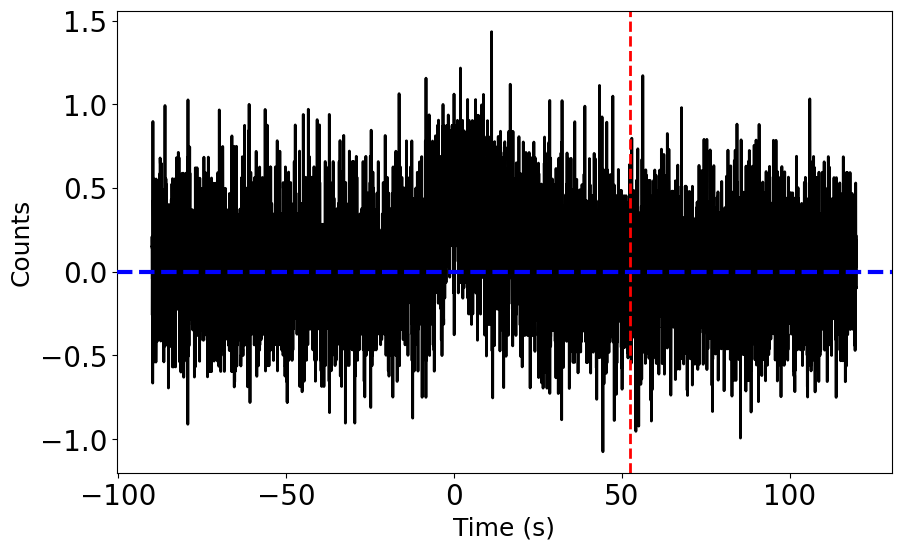

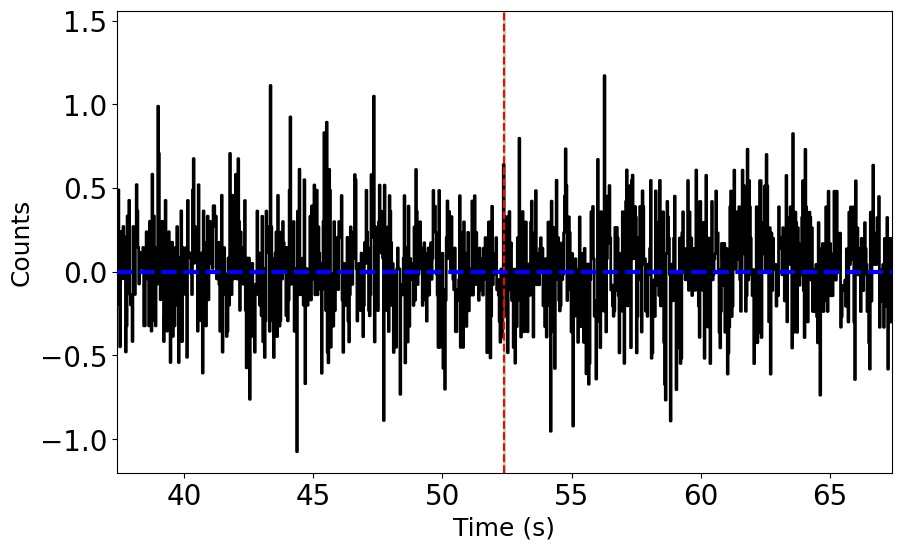

In [108]:
# plot the light curve with mepsa peaks
plt.figure(figsize=(10,6))
rebinf = 32
x_reb1,y_reb1,z_reb1 = rebin_lc_genau(time_cut, counts_no_bkgd_tot_cut, err_counts_tot_cut,rebinf,ren=True)
plt.step(x_reb1, y_reb1, where='mid', label=f'Bkgd Subtracted LC Rebin {rebinf} ', color='k', linewidth=2)
plt.axvline(t_mvt, color='red', linestyle='--', label='MVT Peak Time', linewidth=2)
plt.axhline(0, color='blue', linestyle='--', linewidth=3,zorder=100)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# zoom on the mvt region
plt.figure(figsize=(10,6))
plt.step(x_reb1, y_reb1, where='mid', label=f'Bkgd Subtracted LC Rebin {rebinf} ', color='k', linewidth=2)
plt.axvline(t_mvt, color='red', linestyle='--', label='MVT Peak Time')
plt.axhline(0, color='blue', linestyle='--', linewidth=3,zorder=100)
plt.axvspan(t_mvt-MVT/2, t_mvt+MVT/2, color='green', alpha=0.3, label='MVT Interval', linewidth=2)

plt.xlim(t_mvt-15, t_mvt+15)

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.plot(time_cut,counts_no_bkgd_tot_cut, label='Bkgd Subtracted LC')


In [90]:
grb_name=fermi_id
path_mepsa_file64 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'64ms_'+used_detectors_str+'_bs.txt'
os.path.exists(path_mepsa_file64)

True

In [25]:
used_detectors_str

'n0_n6_n9'

In [75]:
SNR1soglia = 7
SNR4soglia = 6.8
SNR64soglia = 6.4
SNR1024soglia = 6
path_dir=f'/astrodata/romain/reduce_gbm_data/{fermi_id}/LC/'


path_save_mvt = '/astrodata/romain/GBM_LC_repository/MVT_new_events/'

def FWHM_mepsa(dT_det,SNR,Nadiac):
    fullw= 10**(-0.31)*(dT_det*(SNR/4.7-1)**0.60)*Nadiac**1.06
    return fullw


def sigma(FWHM):
    return FWHM*(10**(-0.13)-1),FWHM*(10**(0.13)-1)


def compute_FWHM_min(path_dir,grb_name,e1,e2,used_detectors_str,save=False,path_save_mvt=''):    
    #chose_det = choose_det_GBM(grb_name)
    chose_det = used_detectors_str
    print(chose_det)
    if e1 == 8 and e2 == 1000 :
        path_mepsa_file1024 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1024ms_'+chose_det+'_bs.txt'
        path_mepsa_file64 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'64ms_'+chose_det+'_bs.txt'
        path_mepsa_file4 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'4ms_'+chose_det+'_bs.txt'
        path_mepsa_file1 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1ms_'+chose_det+'_bs.txt'
    else:
        path_mepsa_file1024 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1024ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file64 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'64ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file4 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'4ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file1 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
    
    print(path_mepsa_file64)
    if os.path.exists(path_mepsa_file1024):
        print('There is MEPSA file at 1024ms !')
        mepsa_file1024 = np.loadtxt(path_mepsa_file1024,ndmin=2,dtype=object)
        timep1024,binTdet1024,SNR1024,Nadiac1024 = np.loadtxt(path_mepsa_file1024,unpack=True,ndmin=2,usecols=[3,4,7,9])
    else:
         print('There is no MEPSA file at 1024ms !')
    if os.path.exists(path_mepsa_file64):
        print('There is MEPSA file at 64ms !')
        mepsa_file64 = np.loadtxt(path_mepsa_file64,ndmin=2,dtype=object)
        timep64,binTdet64,SNR64,Nadiac64= np.loadtxt(path_mepsa_file64,unpack=True,ndmin=2,usecols=[3,4,7,9])
    else:
        print('There is no MEPSA file at 64ms !')
        return Exception('there is no 64ms mepsa file')
        
   
    if os.path.exists(path_mepsa_file4):
        print('There is MEPSA file at 4ms !')
        mepsa_file4n = np.loadtxt(path_mepsa_file4,ndmin=2,dtype=object)
        timep4n,binTdet4n,SNR4n,Nadiac4n = np.loadtxt(path_mepsa_file4,unpack=True,ndmin=2,usecols=[3,4,7,9])
        idx4 = np.isfinite(SNR4n)
        timep4,binTdet4,Nadiac4,SNR4 = timep4n[idx4],binTdet4n[idx4],Nadiac4n[idx4],SNR4n[idx4]
        mepsa_file4=mepsa_file4n[idx4]
    else:
        print('There is no MEPSA file at 4ms !')
    if os.path.exists(path_mepsa_file1):
        print('There is MEPSA file at 1ms !')
        mepsa_file1n = np.loadtxt(path_mepsa_file1,ndmin=2,dtype=object)
        timep1n,binTdet1n,SNR1n,Nadiac1n = np.loadtxt(path_mepsa_file1,unpack=True,ndmin=2,usecols=[3,4,7,9])
        idx1 = np.isfinite(SNR1n)
        timep1,binTdet1,Nadiac1,SNR1 = timep1n[idx1],binTdet1n[idx1],Nadiac1n[idx1],SNR1n[idx1]
        mepsa_file1=mepsa_file1n[idx1]
    else:
        print('There is no MEPSA file at 1ms !')
        
#-------------------------------------------------------------------------       

    if np.any(SNR64>SNR64soglia):
        #print('step1')
        idx64snr = np.where((SNR64)>SNR64soglia)[0]
        timep64snr = timep64[idx64snr]
        mepsa_file64snr = mepsa_file64[idx64snr]
        binTdet64snr = binTdet64[idx64snr]
        Nadiac64snr = Nadiac64[idx64snr]
        SNR64snr = SNR64[idx64snr]
        if np.all(binTdet64snr>0.128):
            
            FWHMs  = FWHM_mepsa(binTdet64snr,SNR64snr,Nadiac64snr)
            idxminfwhm64= np.argmin(FWHMs)
            FWHM_min = FWHMs[idxminfwhm64]
            sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
            if save == True:
                np.savetxt(path_save_mvt+'FWHM_min_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file64snr[idxminfwhm64].T,fmt="%s",newline=" ")
            print('Peak time:',timep64snr[idxminfwhm64],'binT det:',binTdet64snr[idxminfwhm64],'SNR:',SNR64snr[idxminfwhm64])
            print('peak taken at 64ms','FWHM=',"%1.3f"%FWHM_min,'s')
            return timep64snr[idxminfwhm64],FWHM_min
        else:
            if not(os.path.exists(path_mepsa_file4)):
                print('You need the 4ms MEPSA file!')
                return 4
            #print('step2')
            if np.any(SNR4>SNR4soglia):
              #  print('step3')
                idx4snr = np.where(SNR4>SNR4soglia)[0]
                mepsa_file4snr = mepsa_file4[idx4snr]
                binTdet4snr = binTdet4[idx4snr]
                Nadiac4snr = Nadiac4[idx4snr]
                SNR4snr = SNR4[idx4snr]
                timep4snr = timep4[idx4snr]
                if np.all(binTdet4snr>0.008):
                    FWHMs  = FWHM_mepsa(binTdet4snr,SNR4snr,Nadiac4snr)
                    idxminfwhm4= np.argmin(FWHMs)
                    FWHM_min = FWHMs[idxminfwhm4]
                    sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                    print('Peak time:',timep4snr[idxminfwhm4],'binT det:',binTdet4snr[idxminfwhm4],'SNR:',SNR4snr[idxminfwhm4])
                    if save == True:
                        np.savetxt(path_save_mvt+'FWHM_min_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                        np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file4snr[idxminfwhm4],fmt="%s",newline=" ")
                    print('peak taken at 4ms','FWHM=',"%1.3f"%FWHM_min,'s')
                    return timep4snr[idxminfwhm4],FWHM_min
                else:
                    if not(os.path.exists(path_mepsa_file1)):
                        print('You need the 1ms MEPSA file!')
                        return 1
                        
                    if np.any(SNR1>SNR1soglia):
                        idx1snr = np.where(SNR1>SNR1soglia)[0]
                        mepsa_file1snr = mepsa_file1[idx1snr]
                        binTdet1snr = binTdet1[idx1snr]
                        Nadiac1snr = Nadiac1[idx1snr]
                        SNR1snr = SNR1[idx1snr]
                        timep1snr = timep1[idx1snr]
                        
                        FWHMs  = FWHM_mepsa(binTdet1snr,SNR1snr,Nadiac1snr)
                        idxminfwhm1= np.argmin(FWHMs)
                        FWHM_min = FWHMs[idxminfwhm1]
                        sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                        print('Peak time:',timep1snr[idxminfwhm1],'binT det:',binTdet1snr[idxminfwhm1],'SNR:',SNR1snr[idxminfwhm1])
                        if save == True:
                            np.savetxt(path_save_mvt+'FWHM_min_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                            np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file1[idxminfwhm1],fmt="%s",newline=" ")
                        print('peak taken at 1ms','FWHM=',"%1.3f"%FWHM_min,'s')
                        return timep1snr[idxminfwhm1],FWHM_min
                    else:
                        FWHMs  = FWHM_mepsa(binTdet4snr,SNR4snr,Nadiac4snr)
                        idxminfwhm4= np.argmin(FWHMs)
                        FWHM_min = FWHMs[idxminfwhm4]
                        sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                        print('Peak time:',timep4snr[idxminfwhm4],'binT det:',binTdet4snr[idxminfwhm4],'SNR:',SNR4snr[idxminfwhm4])
                        if save == True:
                            np.savetxt(path_save_mvt+'FWHM_min_upper_limit_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                            np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file4snr[idxminfwhm4],fmt="%s",newline=" ")
                        print('peak taken at 4ms as an upper limit','FWHM=',"%1.3f"%FWHM_min,'s')
                        return timep4snr[idxminfwhm4],FWHM_min


            else:
                
                FWHMs  = FWHM_mepsa(binTdet64snr,SNR64snr,Nadiac64snr)
                idxminfwhm64= np.argmin(FWHMs)
                FWHM_min = FWHMs[idxminfwhm64]
                sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                print('Peak time:',timep64snr[idxminfwhm64],'binT det:',binTdet64snr[idxminfwhm64],'SNR:',SNR64snr[idxminfwhm64])
                sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                if save == True:
                    np.savetxt(path_save_mvt+'FWHM_min_upper_limit_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                    np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file64snr[idxminfwhm64],fmt="%s",newline=" ")
                print('peak taken at 64ms as an upper limit','FWHM=',"%1.3f"%FWHM_min,'s')
                return timep64snr[idxminfwhm64],FWHM_min
    else:
        if not(os.path.exists(path_mepsa_file1024)):
            print('You need the 1024ms MEPSA file!')
            return 1024
            #return 0
        if np.any(SNR1024>SNR1024soglia):
            idx1024snr = np.where(SNR1024>SNR1024soglia)[0]
            timep1024snr = timep1024[idx1024snr]
            mepsa_file1024snr = mepsa_file1024[idx1024snr]
            binTdet1024snr = binTdet1024[idx1024snr]
            Nadiac1024snr = Nadiac1024[idx1024snr]
            SNR1024snr = SNR1024[idx1024snr]
            FWHMs  = FWHM_mepsa(binTdet1024snr,SNR1024snr,Nadiac1024snr)
            idxminfwhm1024= np.argmin(FWHMs)
            FWHM_min = FWHMs[idxminfwhm1024]
            sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
            print('Peak time:',timep1024snr[idxminfwhm1024],'binT det:',binTdet1024snr[idxminfwhm1024],'SNR:',SNR1024snr[idxminfwhm1024])
            if save == True:
                np.savetxt(path_save_mvt+'FWHM_min_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                np.savetxt(path_save_mvt+'FWHM_min_mepsa_line_'+grb_name+'_{0}_{1}.txt'.format(e1,e2),mepsa_file1024snr[idxminfwhm1024],fmt="%s",newline=" ")
            print('peak taken at 1024ms','FWHM=',"%1.3f"%FWHM_min,'s')
            return timep1024snr[idxminfwhm1024],FWHM_min
        else:
            print('None peak taken')
            return -1
            
            
            
            
    
def compute_detection_timescale(grb_name,e1,e2):
    if (e1 == 8) and (e2 == 1000):
        path_dir='/astrodata/romain/MVT_MEPSA_RESULTS_ALL/'
    else:
        print('im ere')
        path_dir='/astrodata/romain/MEPSA_MVT_{0}_{1}/'.format(e1,e2)
    chose_det = get_chos_dets_file(grb_name)
    print(chose_det)
    
    if (e1 == 8) and (e2 == 1000):
        path_mepsa_file1024 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1024ms_'+chose_det+'_bs.txt'
        path_mepsa_file64 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'64ms_'+chose_det+'_bs.txt'
        path_mepsa_file4 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'4ms_'+chose_det+'_bs.txt'
        path_mepsa_file1 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1ms_'+chose_det+'_bs.txt'
    else:
        path_mepsa_file1024 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1024ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file64 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'64ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file4 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'4ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
        path_mepsa_file1 =path_dir+'mepsa_res_'+grb_name+'_LC_'+'1ms_'+chose_det+'_bs_{0}_{1}.txt'.format(e1,e2)
    print(path_mepsa_file64)
    if os.path.exists(path_mepsa_file1024):
        print('There is MEPSA file at 1024ms !')
        mepsa_file1024 = np.loadtxt(path_mepsa_file1024,ndmin=2,dtype=object)
        rebf1024,timep1024,binTdet1024,peakR1024,epeakR1024,SNR1024,Nadiac1024 = np.loadtxt(path_mepsa_file1024,unpack=True,ndmin=2,usecols=[1,3,4,5,6,7,9])
    else:
         print('There is no MEPSA file at 1024ms !')
    
    if os.path.exists(path_mepsa_file64):
        print('There is MEPSA file at 64ms !')
        mepsa_file64 = np.loadtxt(path_mepsa_file64,ndmin=2,dtype=object)
        rebf64,timep64,binTdet64,peakR64,epeakR64,SNR64,Nadiac64 = np.loadtxt(path_mepsa_file64,unpack=True,ndmin=2,usecols=[1,3,4,5,6,7,9])
    else:
        print('There is no MEPSA file at 64ms !')
        
    if os.path.exists(path_mepsa_file4):
        print('There is MEPSA file at 4ms !')
        mepsa_file4n = np.loadtxt(path_mepsa_file4,ndmin=2,dtype=object)
        rebf4n,timep4n,binTdet4n,peakR4n,epeakR4n,SNR4n,Nadiac4n = np.loadtxt(path_mepsa_file4,unpack=True,ndmin=2,usecols=[1,3,4,5,6,7,9])
        idx4 = np.isfinite(SNR4n)
        rebf4,timep4,binTdet4,peakR4,epeakR4,SNR4,Nadiac4 = rebf4n[idx4],timep4n[idx4],binTdet4n[idx4],peakR4n[idx4],epeakR4n[idx4],SNR4n[idx4],Nadiac4n[idx4]
        mepsa_file4=mepsa_file4n[idx4]
    else:
        print('There is no MEPSA file at 4ms !')
  
    if os.path.exists(path_mepsa_file1):
        print('There is MEPSA file at 1ms !')
        mepsa_file1n = np.loadtxt(path_mepsa_file1,ndmin=2,dtype=object)
        rebf1n,timep1n,binTdet1n,peakR1n,epeakR1n,SNR1n,Nadiac1n = np.loadtxt(path_mepsa_file1,unpack=True,ndmin=2,usecols=[1,3,4,5,6,7,9])
        idx1 = np.isfinite(SNR1n)
        rebf1,timep1,binTdet1,peakR1,epeakR1,SNR1,Nadiac1 = rebf1n[idx1],timep1n[idx1],binTdet1n[idx1],peakR1n[idx1],epeakR1n[idx1],SNR1n[idx1],Nadiac1n[idx1]
        mepsa_file1=mepsa_file1n[idx1]
    else:
        print('There is no MEPSA file at 1ms !')
        
#-------------------------------------------------------------------------       

    if np.any(SNR64>SNR64soglia):
        #print('step1')
        idx64snr = np.where((SNR64)>SNR64soglia)[0]
        timep64snr = timep64[idx64snr]
        peakR64snr = peakR64[idx64snr]
        epeakR64snr = epeakR64[idx64snr]
        mepsa_file64snr = mepsa_file64[idx64snr]
        binTdet64snr = binTdet64[idx64snr]
        Nadiac64snr = Nadiac64[idx64snr]
        SNR64snr = SNR64[idx64snr]
        rebf64snr=rebf64[idx64snr]
        
        if np.all(binTdet64snr>0.128):
            
            FWHMs  = FWHM_mepsa(binTdet64snr,SNR64snr,Nadiac64snr)
            idxminfwhm64= np.argmin(FWHMs)
            FWHM_min = FWHMs[idxminfwhm64]
            sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
            #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_'+grb_name+'.txt',np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
            #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file64snr[idxminfwhm64].T,fmt="%s",newline=" ")
            print('Peak time:',timep64snr[idxminfwhm64],'binT det:',binTdet64snr[idxminfwhm64],'SNR:',SNR64snr[idxminfwhm64])
            print('peak taken at 64ms','FWHM=',"%1.3f"%FWHM_min,'s')
            return rebf64snr[idxminfwhm64],timep64snr[idxminfwhm64],binTdet64snr[idxminfwhm64],peakR64snr[idxminfwhm64],epeakR64snr[idxminfwhm64],SNR64snr[idxminfwhm64],Nadiac64snr[idxminfwhm64],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p
        else:
            if not(os.path.exists(path_mepsa_file4)):
                print('You need the 4ms MEPSA file!')
                raise Exception
                return 4
            #print('step2')
            if np.any(SNR4>SNR4soglia):
              #  print('step3')
                idx4snr = np.where(SNR4>SNR4soglia)[0]
                mepsa_file4snr = mepsa_file4[idx4snr]
                binTdet4snr = binTdet4[idx4snr]
                peakR4snr = peakR4[idx4snr]
                epeakR4snr = epeakR4[idx4snr]
                Nadiac4snr = Nadiac4[idx4snr]
                SNR4snr = SNR4[idx4snr]
                timep4snr = timep4[idx4snr]
                rebf4snr=rebf4[idx4snr]
                if np.all(binTdet4snr>0.008):
                    FWHMs  = FWHM_mepsa(binTdet4snr,SNR4snr,Nadiac4snr)
                    idxminfwhm4= np.argmin(FWHMs)
                    FWHM_min = FWHMs[idxminfwhm4]
                    sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                    print('Peak time:',timep4snr[idxminfwhm4],'binT det:',binTdet4snr[idxminfwhm4],'SNR:',SNR4snr[idxminfwhm4])
                    #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_'+grb_name+'.txt',np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                    #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file4snr[idxminfwhm4],fmt="%s",newline=" ")
                    print('peak taken at 4ms','FWHM=',"%1.3f"%FWHM_min,'s')
                    return rebf4snr[idxminfwhm4],timep4snr[idxminfwhm4],binTdet4snr[idxminfwhm4],peakR4snr[idxminfwhm4],epeakR4snr[idxminfwhm4],SNR4snr[idxminfwhm4],Nadiac4snr[idxminfwhm4],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p
                else:
                    if not(os.path.exists(path_mepsa_file1)):
                        print('You need the 1ms MEPSA file!')
                        raise Exception
                        return 1
                        
                    if np.any(SNR1>SNR1soglia):
                        idx1snr = np.where(SNR1>SNR1soglia)[0]
                        mepsa_file1snr = mepsa_file1[idx1snr]
                        binTdet1snr = binTdet1[idx1snr]
                        Nadiac1snr = Nadiac1[idx1snr]
                        SNR1snr = SNR1[idx1snr]
                        timep1snr = timep1[idx1snr]
                        peakR1snr=peakR1[idx1snr]
                        epeakR1snr=epeakR1[idx1snr]
                        rebf1snr=rebf1[idx1snr]
                        
                        FWHMs  = FWHM_mepsa(binTdet1snr,SNR1snr,Nadiac1snr)
                        idxminfwhm1= np.argmin(FWHMs)
                        FWHM_min = FWHMs[idxminfwhm1]
                        sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                        print('Peak time:',timep1snr[idxminfwhm1],'binT det:',binTdet1snr[idxminfwhm1],'SNR:',SNR1snr[idxminfwhm1])
                        #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_'+grb_name+'.txt',np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                        #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file1[idxminfwhm1],fmt="%s",newline=" ")
                        print('peak taken at 1ms','FWHM=',"%1.3f"%FWHM_min,'s')
                        return rebf1snr[idxminfwhm1],timep1snr[idxminfwhm1],binTdet1snr[idxminfwhm1],peakR1snr[idxminfwhm1],epeakR1snr[idxminfwhm1],SNR1snr[idxminfwhm1],Nadiac1snr[idxminfwhm1],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p
                    else:
                        FWHMs  = FWHM_mepsa(binTdet4snr,SNR4snr,Nadiac4snr)
                        idxminfwhm4= np.argmin(FWHMs)
                        FWHM_min = FWHMs[idxminfwhm4]
                        sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                        print('Peak time:',timep4snr[idxminfwhm4],'binT det:',binTdet4snr[idxminfwhm4],'SNR:',SNR4snr[idxminfwhm4])
                        #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_upper_limit_'+grb_name,np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                        #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file4snr[idxminfwhm4],fmt="%s",newline=" ")
                        print('peak taken at 4ms as an upper limit','FWHM=',"%1.3f"%FWHM_min,'s')
                        return rebf4snr[idxminfwhm4],timep4snr[idxminfwhm4],binTdet4snr[idxminfwhm4],peakR4snr[idxminfwhm4],epeakR4snr[idxminfwhm4],SNR4snr[idxminfwhm4],Nadiac4snr[idxminfwhm4],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p


            else:
                
                FWHMs  = FWHM_mepsa(binTdet64snr,SNR64snr,Nadiac64snr)
                idxminfwhm64= np.argmin(FWHMs)
                FWHM_min = FWHMs[idxminfwhm64]
                sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                print('Peak time:',timep64snr[idxminfwhm64],'binT det:',binTdet64snr[idxminfwhm64],'SNR:',SNR64snr[idxminfwhm64])
                sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
                np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_upper_limit_'+grb_name,np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
                np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file64snr[idxminfwhm64],fmt="%s",newline=" ")
                print('peak taken at 64ms as an upper limit','FWHM=',"%1.3f"%FWHM_min,'s')
                return rebf64snr[idxminfwhm64], timep64snr[idxminfwhm64],binTdet64snr[idxminfwhm64],peakR64snr[idxminfwhm64],epeakR64snr[idxminfwhm64],SNR64snr[idxminfwhm64],Nadiac64snr[idxminfwhm64],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p
    else:
        if not(os.path.exists(path_mepsa_file1024)):
            print('You need the 1024ms MEPSA file!')
            raise Exception
            #return binTdet1024snr[idxminfwhm1024]
            #return 0
        if np.any(SNR1024>SNR1024soglia):
            idx1024snr = np.where(SNR1024>SNR1024soglia)[0]
            timep1024snr = timep1024[idx1024snr]
            mepsa_file1024snr = mepsa_file1024[idx1024snr]
            binTdet1024snr = binTdet1024[idx1024snr]
            peakR1024snr=peakR1024[idx1024snr]
            epeakR1024snr=epeakR1024[idx1024snr]
            Nadiac1024snr = Nadiac1024[idx1024snr]
            SNR1024snr = SNR1024[idx1024snr]
            rebf1024snr=rebf1024[idx1024snr]
            
            FWHMs  = FWHM_mepsa(binTdet1024snr,SNR1024snr,Nadiac1024snr)
            idxminfwhm1024= np.argmin(FWHMs)
            FWHM_min = FWHMs[idxminfwhm1024]
            sigma_FWHM_min_m,sigma_FWHM_min_p = sigma(FWHM_min)
            print('Peak time:',timep1024snr[idxminfwhm1024],'binT det:',binTdet1024snr[idxminfwhm1024],'SNR:',SNR1024snr[idxminfwhm1024])
            #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_'+grb_name+'.txt',np.array([FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p]))
            #np.savetxt('/astrodata/romain/GBM_LC_repository/MVT_ALL_GRBs/FWHM_min_mepsa_line_'+grb_name+'.txt',mepsa_file1024snr[idxminfwhm1024],fmt="%s",newline=" ")
            print('peak taken at 1024ms','FWHM=',"%1.3f"%FWHM_min,'s')
            return rebf1024snr[idxminfwhm1024],timep1024snr[idxminfwhm1024],binTdet1024snr[idxminfwhm1024],peakR1024snr[idxminfwhm1024],epeakR1024snr[idxminfwhm1024],SNR1024snr[idxminfwhm1024],Nadiac1024snr[idxminfwhm1024],FWHM_min,sigma_FWHM_min_m,sigma_FWHM_min_p
        else:
            print('None peak taken')
            return None,None,None,None,None,None,None,None,None

/astrodata/romain/reduce_gbm_data/functions.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
No handles with labels found to put in legend.


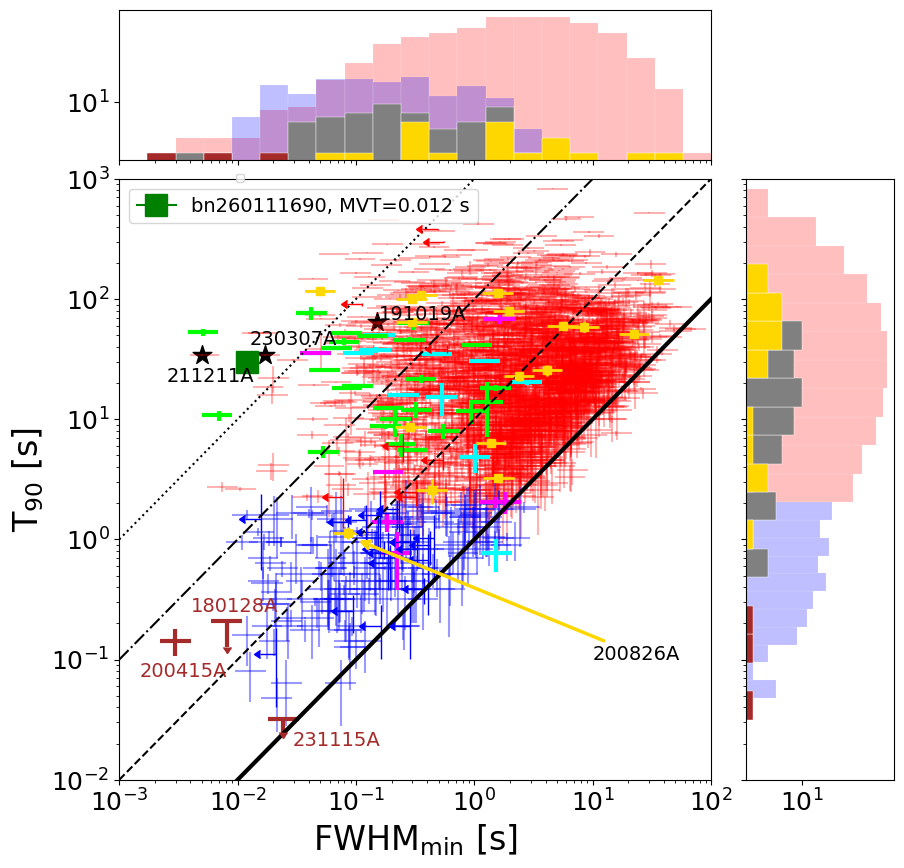

In [109]:
# format mvt
mvt_format = float("%1.3f"%(MVT))
plot_MVT_(mvt_format,30,fermi_id)

In [99]:
df_mepsa

,Peak,RebinFactor,BinPhase,PeakTime,BinTime,PeakRate,PeakRateError,SNR,Criteria,Adjacents,FWHM
0,1,3,2,44.663,0.003,4.779,1.259,3.79,40,8,NaN


/tmp/ipykernel_1091760/1001500407.py:11: RuntimeWarning: invalid value encountered in power
  fullw= 10**(-0.31)*(dT_det*(SNR/4.7-1)**0.60)*Nadiac**1.06


Text(0.5, 1.0, 'GBM Light Curve for bn260111690 with MEPSA Peaks')

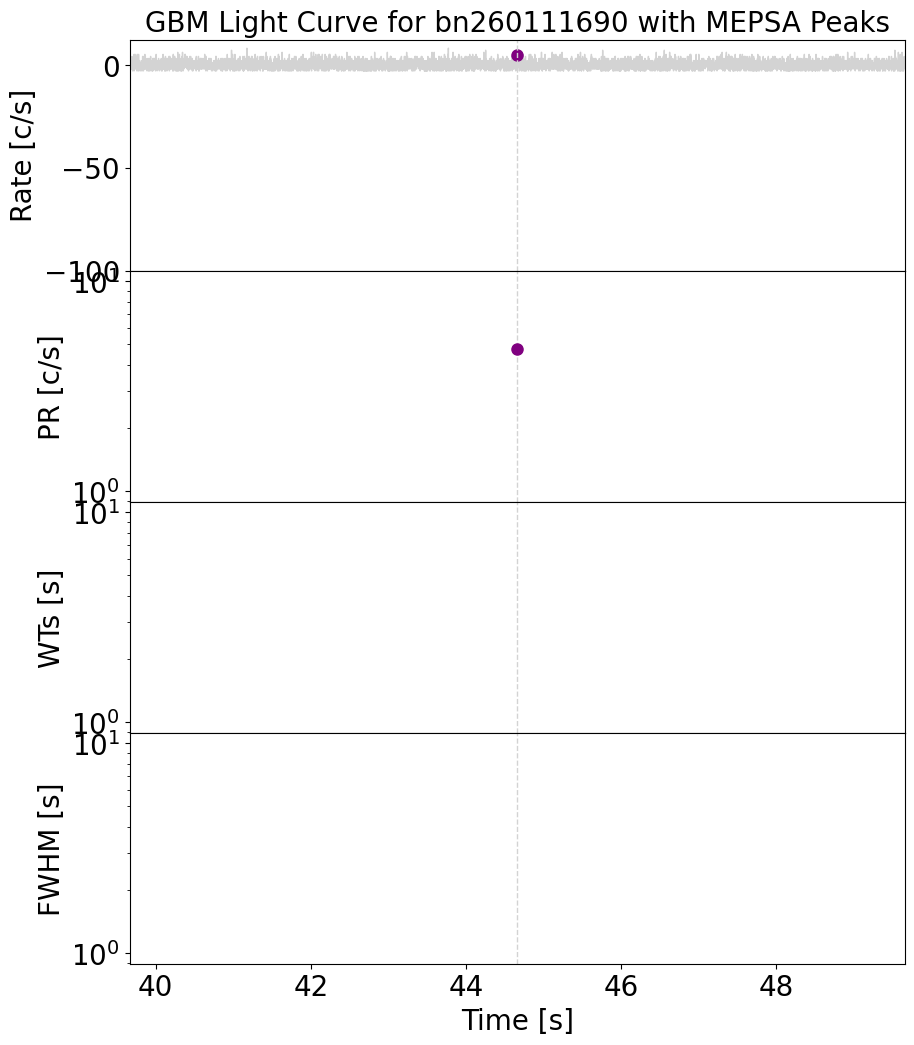

In [110]:
df_mepsa['FWHM'] = FWHM_mepsa(df_mepsa['BinTime'].values,df_mepsa['SNR'].values,df_mepsa['Adjacents'].values)
# compute waiting times between peaks
waiting_times = df_mepsa['PeakTime'].values[1:] - df_mepsa['PeakTime'].values[:-1]
# compute medium time between peaks
med_time = 0.5*(df_mepsa['PeakTime'].values[1:] + df_mepsa['PeakTime'].values[:-1])
# make a three panel plot with peak rate, waiting time and fwhm versus peak time
fig,axs = plt.subplots(4,1, figsize=(10,12),sharex=True) 
# set vertical space to zero
plt.subplots_adjust(hspace=0)   
data_color='purple'
axs[0].step(time_cut, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='lightgray', linewidth=1)
axs[0].plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,'o',c=data_color, label='MEPSA Peaks', markersize=8)
for t in df_mepsa['PeakTime'].values:
    for i in range(4):
        axs[i].axvline(t, color='lightgray', linestyle='--', linewidth=1)
axs[0].errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2,c=data_color,ls='')
# peak rate
axs[1].plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,'o',c=data_color, label='MEPSA Peaks', markersize=8)
axs[1].errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2,c=data_color,ls='')
axs[2].plot(med_time, waiting_times,'o',c=data_color, label='Waiting Times', markersize=8)
axs[3].plot(df_mepsa['PeakTime'].values, df_mepsa['FWHM'].values, 'o', c=data_color, label='FWHM', markersize=8)
axs[0].set_xlim(df_mepsa['PeakTime'].values.min()-5,df_mepsa['PeakTime'].values.max()+5)
axs[0].set_ylim(-100,1.1*counts_no_bkgd_tot_cut.max())
# set logspace for subpanels 1 to 3
for i in range(1,4):
    axs[i].set_yscale('log')

# set tick fontsize
for i in range(4):
    axs[i].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_ylabel('Rate [c/s]', fontsize=20)
axs[1].set_ylabel('PR [c/s]', fontsize=20)
axs[2].set_ylabel('WTs [s]', fontsize=20)
axs[3].set_ylabel('FWHM [s]', fontsize=20)
axs[3].set_xlabel('Time [s]', fontsize=20)
axs[0].set_title(f'GBM Light Curve for {fermi_id} with MEPSA Peaks', fontsize=20)

In [111]:
file_path_scat = find_files(f'{fermi_id}/glg_bcat_all_{fermi_id}_v*.fit')

filename = file_path_scat
with fits.open(filename) as hdul:
    # Access the Primary Header (Metadata)
    header = hdul[0].header
    t90 = hdul[0].header['T90']
    t90_start = hdul[0].header['T90START']
    fluence = hdul[0].header['FLU']
    # Print every line ("Card") nicely
    print(f"{'KEYWORD':<10} = {'VALUE':<20} / {'COMMENT'}")
    print("-" * 60)
    
    for card in header.cards:
        print(card)

OSError: File-like object does not have a 'write' method, required for mode 'ostream'.

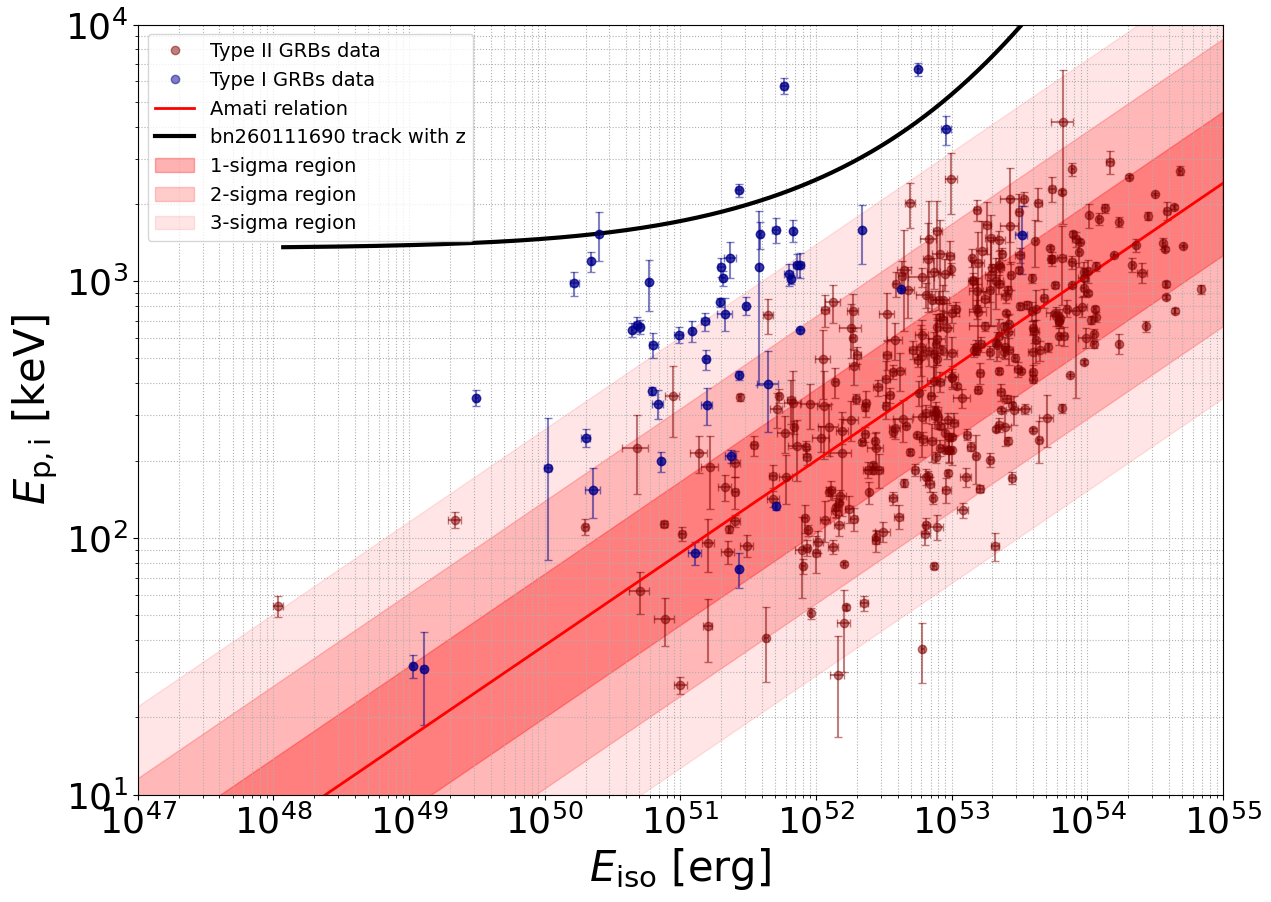

In [ ]:
# E_p-E_iso without redshift

# import the cosmoglogy
from astropy.cosmology import Planck18
from astropy import units as u

Ep =  # in keV
fluence = 5e-6

 # ---- REDSHIFT RANGE ----
z_range = np.linspace(0.01, 10, 5000)
Epi_range = []
E_iso_range = []
for z in z_range:
    D_L = Planck18.luminosity_distance(z).to(u.cm).value  # in cm
    E_iso = 4 * np.pi * D_L**2 * fluence / (1 + z)  # in erg    
    Epi = Ep * (1 + z)  # in keV
    Epi_range.append(Epi)
    E_iso_range.append(E_iso)

plot_Amati_rel()
plt.plot(E_iso_range, Epi_range, 'k-', lw=3,label=f'{fermi_id} track with z')
plt.legend(fontsize=14)

sigma from Amati relation: 1.3652816940154442


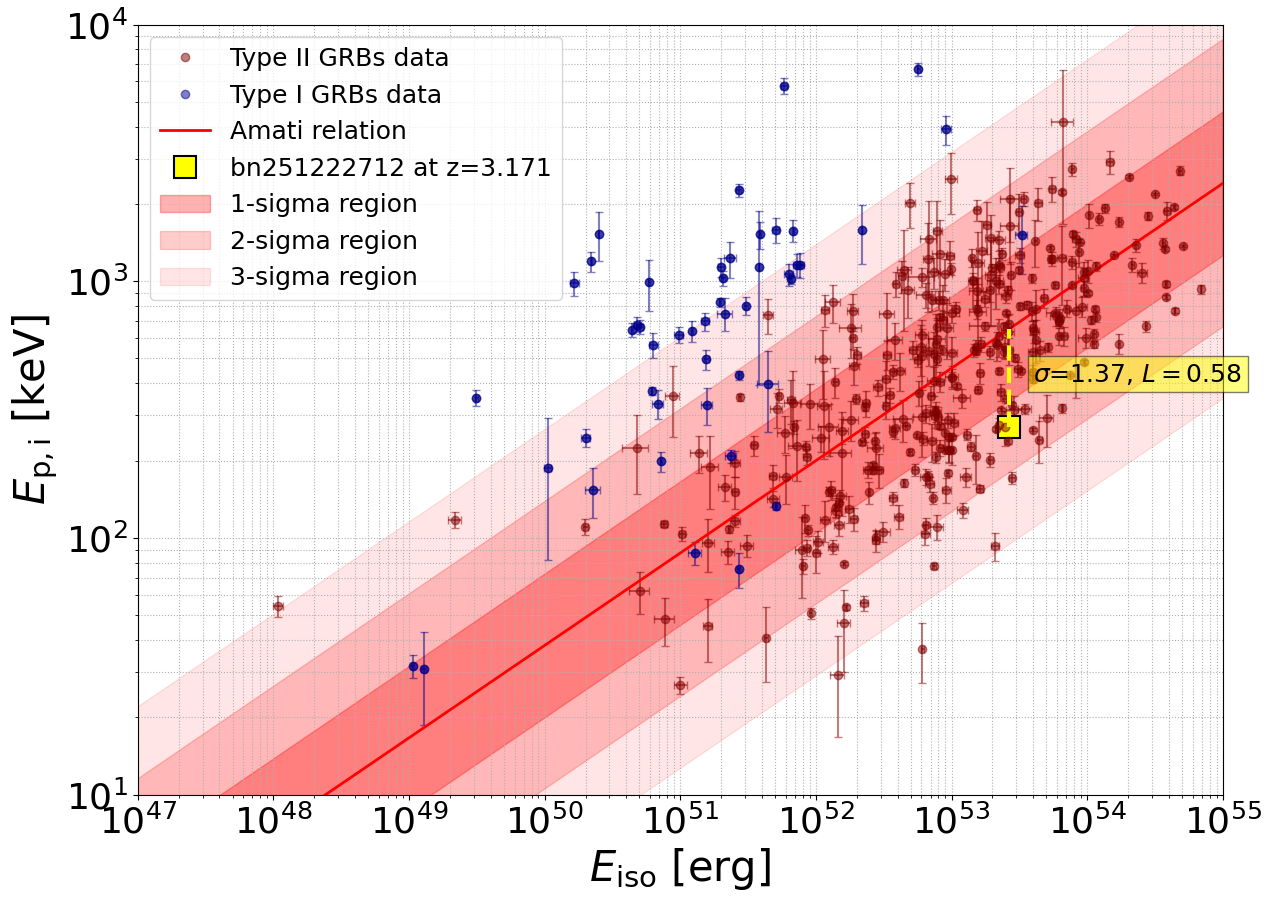

In [ ]:
# Ep,i-E_iso with redshift 
# import the cosmoglogy
from astropy.cosmology import Planck18
from astropy import units as u
z = 3.171  # redfshift of the source (when known)
D_L = Planck18.luminosity_distance(z).to(u.cm).value

fluence = 1.20552e-05
fluence_err = 1.55095e-07
err_log_fluence = 0.5*(np.log10(fluence + fluence_err) - np.log10(fluence-fluence_err))

E_iso = 4 * np.pi * D_L**2 * fluence / (1 + z)  # in erg
err_log_Eiso = err_log_fluence

Ep = 64.9 # peak energy
err_Ep = 0.8 
Epi = (1+z)*Ep
err_Epi = (1+z)*err_Ep
err_log_Epi = 0.5*(np.log10(Epi + err_Epi) - np.log10(Epi - err_Epi))

plot_Amati_rel()

K_L = 200
m_L = 0.36
sigma_L = 0.28
q_L = np.log10(K_L)-52*m_L

LL =log_likelihood([m_L, q_L, sigma_L], np.log10(E_iso),np.log10(Epi),err_log_Eiso,err_log_Epi)
LL = round(L,2)
plt.plot([E_iso], [Epi], 'ks', markersize=16, label=rf'{fermi_id} at z={z}', markerfacecolor='yellow', markeredgecolor='black', markeredgewidth=1.5)
# show vertical distance to the amati relation
plt.axvline(E_iso, ymin= (np.log10(Epi)-1)/3, ymax= (m_L*np.log10(E_iso)+q_L-1)/3 ,  color='yellow', linestyle='--', linewidth=3,zorder=20)
# plot text showing the vertical distance value and likelihood
sigma_grb = (m_L * np.log10(E_iso) + q_L - np.log10(Epi))/sigma_L
plt.text(E_iso*1.5, Epi*1.5, rf'$\sigma$={sigma_grb:.2f}'+rf', $L={LL:.2f}$', fontsize=18, color='black', bbox=dict(facecolor='yellow', alpha=0.5))
print(f'sigma from Amati relation: {sigma_grb}')

plt.legend(fontsize=18)